<font size="+3">Part I - Bootstrapping Swap Curves</font>

| Name             | Student ID |
|------------------|------------|
| Ishani Maitra| [01506460]  |
|Dragos Horge   | [01507705]|

>[General Funcions](#scrollTo=eoJCncTPlse0)

>[Overnight Index Swap (OIS)](#scrollTo=qzJYX0qENv0Y)

>>[Data Preparation](#scrollTo=afMjZlPVl4po)

>>[Discount Factor and Forward Rate Calculation](#scrollTo=yx3ZUC7fl8th)

>>>[Solving $f_0$, D(0, 6m), $f_1$, D(0, 1y)](#scrollTo=fIwd18S4mIKE)

>>>>[For the 1st equation for $f_0$](#scrollTo=fIwd18S4mIKE)

>>>>[For the 2nd equation for $f_1$](#scrollTo=fIwd18S4mIKE)

>>>[Bootstrapping discount factors for $t \ge 2$](#scrollTo=-2XzW1e5ow3G)

>>[OIS Discount Curve](#scrollTo=VcDJA5U5r6HR)

>[LIBOR/IRS](#scrollTo=PfvBqu-INzFZ)

>>[Data Preparation](#scrollTo=WGmtGde9r_y7)

>>[LIBOR Discount Factor Bootstrapping](#scrollTo=97YhN4LcsEGM)

>>[LIBOR Discount Curve](#scrollTo=9cDOYsUpAhzH)

>[Forward Swap Rates](#scrollTo=x6iw5RsDgMeU)

>[Final Formatting](#scrollTo=007ypyMWAcZ1)



In [31]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import inspect
from scipy.optimize import brentq
from scipy.optimize import bisect
import warnings
warnings.filterwarnings("ignore")

#General Funcions

In [32]:
def list_functions_with_purpose(module_globals):
    print(f"{'Function Name':<30} {'Inputs':<40} Purpose")
    print("-" * 100)
    for name, obj in module_globals.items():
        if inspect.isfunction(obj) and obj.__module__ == '__main__':
            sig = inspect.signature(obj)
            doc = inspect.getdoc(obj)
            short_doc = doc.split('\n')[0] if doc else 'No description'
            print(f"{name:<30} {str(sig):<40} {short_doc}")

In [33]:
def tenor_to_years(tenor):
    """Convert tenor strings like '6m', '1y', etc. to fractional years."""
    if isinstance(tenor, str):
        tenor = tenor.strip().lower()
        if tenor.endswith('m'):
            return float(tenor[:-1]) / 12
        elif tenor.endswith('y'):
            return float(tenor[:-1])
    return float(tenor)

In [34]:
def DF_to_OR(d,i):
    return ((1/d)**(1/360*i)-1)*360
def OR_to_DF(f,i):
    return 1/(1+f/360)**(360*i)

In [35]:
def plot_discount_curve(interpolated_df, title, column = 'Discount Factor'):
    plt.figure(figsize=(10, 5))
    plt.plot(interpolated_df['Tenor'], interpolated_df[column], marker='o', color='navy')
    plt.title(title)
    plt.xlabel('Tenor (Years)')
    plt.ylabel('Discount Factor')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Overnight Index Swap (OIS)

## Data Preparation

In [36]:
ois = pd.read_excel("IR_Data.xlsx", sheet_name="OIS")
ois_rates = ois.iloc[:, 0:3]
ois_rates

,Tenor,Product,Rate
0,6m,OIS,0.00250
1,1y,OIS,0.00300
2,2y,OIS,0.00325
3,3y,OIS,0.00335
4,4y,OIS,0.00350
5,5y,OIS,0.00360
6,7y,OIS,0.00400
7,10y,OIS,0.00450
8,15y,OIS,0.00500
9,20y,OIS,0.00525


In [37]:
ois_info = ois.iloc[0:3,4:6]
ois_info.columns = ["Details","Convention"]
ois_info

,Details,Convention
0,Day Count Convention,30/360
1,O/N Leg Frequency,Daily
2,Fixed Leg Frequency,Annual


In [38]:
ois_rates["Tenor"] = ois_rates["Tenor"].apply(tenor_to_years)

In [39]:
Tenor = pd.DataFrame({"Tenor": np.arange(0,30,1)})
ois_rates1 = pd.merge(ois_rates, Tenor, on="Tenor",how="outer")
ois_rates1 = ois_rates1.sort_values(by="Tenor").reset_index(drop=True)
ois_rates1= ois_rates1.drop(["Product"], axis=1)
ois_rates1 = ois_rates1.drop(ois_rates.index[0]).reset_index(drop=True)
ois_rates1

,Tenor,Rate
0,0.5,0.00250
1,1.0,0.00300
2,2.0,0.00325
3,3.0,0.00335
4,4.0,0.00350
5,5.0,0.00360
6,6.0,NaN
7,7.0,0.00400
8,8.0,NaN
9,9.0,NaN


## Discount Factor and Forward Rate Calculation

### Solving $f_0$, D(0, 6m), $f_1$, D(0, 1y)



* When setting up the equations, the discount factors appear on both sides and cancel out. This cancellation allows us to solve directly for the unknown daily compounded rates $f_i$ without needing the discount factors explicitly.

#### For the 1st equation for $f_0$

We have:
$$
D(0, 6m) \times (0.5 \times r_0) = D(0, 6m) \times \left[\left(1 + \frac{f_0}{360}\right)^{\Delta_0} - 1\right]
$$

Since $D(0, 6m)$ appears on both sides, it cancels:
$$
0.5 \times r_0 = \left(1 + \frac{f_0}{360}\right)^{180} - 1
$$
$$
\left(1 + \frac{f_0}{360}\right)^{180} = 1 + 0.5 \times 0.0025 = 1.00125
$$
$$
f_0 = 360 \left[\left(1.00125\right)^{\frac{1}{180}} - 1\right]
$$

---

#### For the 2nd equation for $f_1$

We have:
$$
D(0, 1y) \times (r_1) = D(0, 1y) \times \left[\left(1 + \frac{f_0}{360}\right)^{180} \left(1 + \frac{f_1}{360}\right)^{180} - 1\right]
$$

Cancelling $D(0, 1y)$:
$$
r_1 = \left(1 + \frac{f_0}{360}\right)^{180} \left(1 + \frac{f_1}{360}\right)^{180} - 1
$$

We already found that:
$$
\left(1 + \frac{f_0}{360}\right)^{180} = 1.00125
$$

Thus,
$$
1.00125 \left(1 + \frac{f_1}{360}\right)^{180} = 1 + 0.003 = 1.003
$$
$$
f_1 = 360 \left[\left(\frac{1.003}{1.00125}\right)^{\frac{1}{180}} - 1\right]
$$

---

Once we have computed $f_0$ and $f_1$, we can plug in back to find $D(0, 6m)$ and $D(0, 1y)$, which is used for sequential bootstrapping later.

In [40]:
#6m forward rate and discount factor
ois_rates1.at[0,'Forward Rate'] =\
(
    ((((ois_rates1.iloc[0]["Tenor"] * ois_rates1.iloc[0]["Rate"])
    +1)**(1/180)
    )-1) * 360


)
ois_rates1.at[0,"Discount Factor"] = OR_to_DF(ois_rates1.iloc[0]["Forward Rate"],ois_rates1.iloc[0]["Tenor"])

#1yr forward rate and discount factor
ois_rates1.at[1,'Forward Rate'] =\
(
    (((((ois_rates1.iloc[1]["Tenor"] * ois_rates1.iloc[1]["Rate"])
    +1)**(1/180)
    )
    /
    (1 + (ois_rates1.iloc[0]["Forward Rate"]/360))
    )-1) * 360


)
ois_rates1.loc[1,"Discount Factor"] =\
(
    1
    /
     (
         (1+ois_rates1.iloc[0]["Forward Rate"]/360)
         **180
         *
          (1+ois_rates1.iloc[1]["Forward Rate"]
           /360)
          **180)
)


ois_rates1

,Tenor,Rate,Forward Rate,Discount Factor
0,0.5,0.00250,0.002498,0.998752
1,1.0,0.00300,0.003493,0.997009
2,2.0,0.00325,NaN,NaN
3,3.0,0.00335,NaN,NaN
4,4.0,0.00350,NaN,NaN
5,5.0,0.00360,NaN,NaN
6,6.0,NaN,NaN,NaN
7,7.0,0.00400,NaN,NaN
8,8.0,NaN,NaN,NaN
9,9.0,NaN,NaN,NaN


### Bootstrapping discount factors for $t \ge 2$

From tenors $t \ge 2$, we can apply:
$$PV_{\text{fix}} =  PV_{\text{float}}$$


**`Fixed Leg`**

Interpolating discount factor using previous tenor values.

$$
D(i+n) = x + \frac{h - i - n}{h - i + 1} \cdot (D(i-1) - x), \quad \text{for } n = 0 \text{ to } h - i
$$

So the fixed leg PV is:

$$
\text{PV}_{\text{fixed}} = R_h \cdot \left( \sum_{j=1}^{i-1} D(j) + \sum_{n=0}^{h-i} D(i+n, x) \right)
$$

**`Floating Leg`**

$$
\text{PV}_{\text{floating}} = R_{i-1} \cdot \sum_{j=1}^{i-1} D(j)
$$

**`Bootstrapping Equation`**

We now solve for x which is the discount factor:

$$
f(x) = \text{PV}_{\text{fixed}} - \text{PV}_{\text{floating}} = 0
$$

This is solved using Brentq's root functions.

**`Forward Rate`**

Once discount factors are bootstrapped, the forward rate is computed as:

$$
F(i) = \left( \frac{D(i-1)}{D(i)} \right)^{1/\Delta t} - 1
$$

Where $\Delta t$ is the accrual period (e.g., $\frac{1}{360} $ for daily compounding).



In [41]:
def ois_df(x, i, h, ois_data, fix, flt):
    # Calculate the difference between the previous discount factor and current discount factor
    # This is the PV of the floating leg over this period.
    pv_flt = ois_data.at[i-1, 'Discount Factor'] - x
    fix_dis_x = 0 #discount factor

    # Generate an array of interpolated discount factors using linear interpolation
    interpolated_discounts = x + (np.arange(h-i+1)/(h-i+1)) * pv_flt

    # Sum up the interpolated discount factors to get the fixed leg PV
    fix_dis_x = np.sum(interpolated_discounts)
    pv_fix = fix_dis_x * ois_data['Rate'][h]

    # residual between the fixed and floating legs:
    residual = pv_fix + fix - pv_flt - flt #should be zero if the correct discount factor is used.
    return residual

In [42]:
i = 2  # Start bootstrapping from the 2nd index as it is the tenor=2
while i <= ois_rates1.iloc[-1]['Tenor']:  # Continue until the last tenor in the data.

    h = i
    # Find the next index h where a valid (non-NaN) OIS rate exists
    while np.isnan(ois_rates1['Rate'][h]):
        h += 1

    k = 1
    fix = 0
    # Accumulate the fixed leg present value up to index i
    while k < i:
        fix_i = ois_rates1.at[k, 'Discount Factor'] * ois_rates1.at[h, 'Rate']
        fix += fix_i
        k += 1

    # Calculate the floating leg present value up to i-1 (till the previous tenor)
    flt = ois_rates1['Rate'][i-1] * ois_rates1['Discount Factor'][1:i].sum()

    # Define function f(x) = fixed leg PV - floating leg PV (use the relationship between PVfix and PVflt)
    f = lambda x: ois_df(x, i, h, ois_rates1, fix, flt)

    # Use Brentq as root search function for the correct discount factor
    D_l = brentq(f, 0, 1)


    for n in range(0, h - i + 1):
        df_index = i + n
        ois_rates1.at[df_index, 'Discount Factor'] = (
            D_l + ((h - i - n) / (h - i + 1)) * (ois_rates1.at[i - 1, 'Discount Factor'] - D_l)
        )

        # Calculate annualized forward rates assuming 360-day convention
        prev_df = ois_rates1.at[df_index - 1, 'Discount Factor']
        curr_df = ois_rates1.at[df_index, 'Discount Factor']
        ois_rates1.at[df_index, 'Forward Rate'] = 360 * ((prev_df / curr_df) ** (1 / 360) - 1)

    # Move to the next available tenor after h
    i = h + 1


In [43]:
ois_rates1

,Tenor,Rate,Forward Rate,Discount Factor
0,0.5,0.00250,0.002498,0.998752
1,1.0,0.00300,0.003493,0.997009
2,2.0,0.00325,0.003495,0.993531
3,3.0,0.00335,0.003545,0.990015
4,4.0,0.00350,0.003946,0.986117
5,5.0,0.00360,0.003996,0.982184
6,6.0,NaN,0.004990,0.977295
7,7.0,0.00400,0.005015,0.972406
8,8.0,NaN,0.005648,0.966929
9,9.0,NaN,0.005680,0.961453


In [44]:
#interpolating for the 0.5 years - for later as LIBOR is semi annual
new_tenors = np.arange(0.5, ois_rates1['Tenor'].max() + 0.5, 0.5)

ois_rates1.set_index('Tenor', inplace=True)

ois_rates1 = ois_rates1.reindex(new_tenors)
ois_rates1[['Rate', 'Forward Rate', 'Discount Factor']] = ois_rates1[['Rate', 'Forward Rate', 'Discount Factor']].interpolate(method='index')

ois_rates1.reset_index(inplace=True)
ois_rates1.rename(columns={'index': 'Tenor'}, inplace=True)
ois_rates1

,Tenor,Rate,Forward Rate,Discount Factor
0,0.5,0.002500,0.002498,0.998752
1,1.0,0.003000,0.003493,0.997009
2,1.5,0.003125,0.003494,0.995270
3,2.0,0.003250,0.003495,0.993531
4,2.5,0.003300,0.003520,0.991773
5,3.0,0.003350,0.003545,0.990015
6,3.5,0.003425,0.003745,0.988066
7,4.0,0.003500,0.003946,0.986117
8,4.5,0.003550,0.003971,0.984150
9,5.0,0.003600,0.003996,0.982184


## OIS Discount Curve

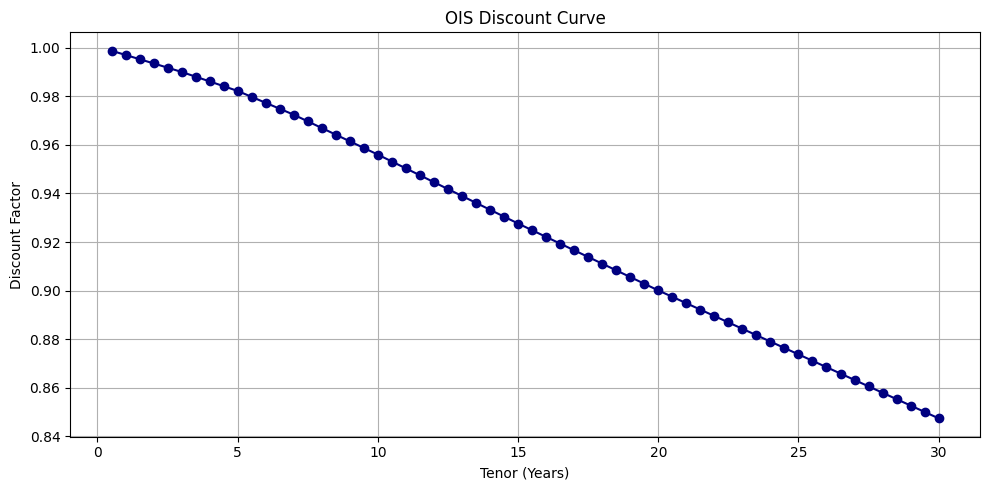

In [45]:
plot_discount_curve(ois_rates1, "OIS Discount Curve")

# LIBOR/IRS

##Data Preparation

In [46]:
irs = pd.read_excel("IR_Data.xlsx")
irs_rates = irs.iloc[:, 0:3]
irs_rates

,Tenor,Product,Rate
0,6m,LIBOR,0.0250
1,1y,IRS,0.0280
2,2y,IRS,0.0300
3,3y,IRS,0.0315
4,4y,IRS,0.0325
5,5y,IRS,0.0330
6,7y,IRS,0.0350
7,10y,IRS,0.0370
8,15y,IRS,0.0400
9,20y,IRS,0.0450


In [47]:
irs_info = irs.iloc[0:3,4:6]
irs_info.columns = ["Details","Convention"]
irs_info

,Details,Convention
0,Day Count Convention,30/360
1,Fixed Leg Freq,Semi-annual
2,Floating Leg Freq,Semi-annual


In [48]:
irs_rates["Tenor"] = irs_rates["Tenor"].apply(tenor_to_years)
irs_rates

,Tenor,Product,Rate
0,0.5,LIBOR,0.0250
1,1.0,IRS,0.0280
2,2.0,IRS,0.0300
3,3.0,IRS,0.0315
4,4.0,IRS,0.0325
5,5.0,IRS,0.0330
6,7.0,IRS,0.0350
7,10.0,IRS,0.0370
8,15.0,IRS,0.0400
9,20.0,IRS,0.0450


In [49]:
Tenor1 = pd.DataFrame({"Tenor": np.arange(0,30.5,0.5)})
irs_rates1 = pd.merge(irs_rates, Tenor1, on="Tenor",how="outer")
irs_rates1 = irs_rates1.sort_values(by="Tenor")
irs_rates1 = irs_rates1.drop(["Product"],axis = 1).reset_index(drop=True)
irs_rates1 = irs_rates1.drop(0).reset_index(drop=True)


In [50]:
ois_rates_final = pd.merge(Tenor1, ois_rates1, how = "outer")
ois_rates_final = ois_rates_final["Discount Factor"].drop(0).reset_index(drop=True).interpolate(method='linear')
ois_irs_rates = pd.concat([irs_rates1, ois_rates_final], axis = 1)
ois_irs_rates.columns = ["Tenor", "Rate", "OIS DF"]

## LIBOR Discount Factor Bootstrapping

We derive the LIBOR discount factors using swap (IRS) rates, assuming payments are semi-annual.

**`D(0,6M)`**

$$
DF(0.5) = \frac{1}{1 + R_1 \cdot 0.5}
$$

Where:
- $ R_1 $ is the IRS rate for 0.5 years (6 months)

**`Compute Forward LIBOR Rate L(6m,1y)`**

$$
L(t_1, t_2) =
\frac{R_2 \cdot \left(DF^{\text{OIS}}(t_1) + DF^{\text{OIS}}(t_2)\right) - R_1 \cdot DF^{\text{OIS}}(t_1)}{DF^{\text{OIS}}(t_2)}
$$

Where:
- $R_2$ is the 1 year IRS rate
- $DF^{\text{OIS}}(t_1)$ is the OIS discount factor for 6 months
- $DF^{\text{OIS}}(t_2)$ is OIS discount factors for 1 year



**`Compute LIBOR Discount Factor at t=1 year`**

Assuming semi-annual compounding:

$$
DF^{\text{LIBOR}}(t_2) =
\frac{DF^{\text{LIBOR}}(t_1)}{1 + \frac{1}{2} \cdot L(t_1, t_2)}
$$



In [51]:
ois_irs_rates.at[0,'LIBOR DF'] =\
(
    1
    /
    (1 + (ois_irs_rates.iloc[0]['Tenor']*ois_irs_rates.iloc[0]['Rate']))
)


L_6m_1y = \
 (
     (ois_irs_rates.loc[1,"Rate"]
      *
       (ois_irs_rates.loc[0,"OIS DF"] + ois_irs_rates.loc[1, "OIS DF"])
       -
      ois_irs_rates.loc[0, "Rate"] * ois_irs_rates.loc[0, "OIS DF"])
     /
     ois_irs_rates.loc[1, "OIS DF"]
 )

ois_irs_rates.loc[1,"LIBOR DF"] = ois_irs_rates.loc[0,"LIBOR DF"]/(L_6m_1y/2+1)

$$
K \sum_{i=1}^{n} \Delta_{i-1} D(0, T_i) = \sum_{i=1}^{n} D(0, T_i) \Delta_{i-1} L(T_{i-1}, T_i)
$$

In [52]:
def calc_flt_leg(pv_flt, df):
    for j in range(0,len(df)-1):
        pv_flt = pv_flt + df["OIS DF"][j+1] * (df["LIBOR DF"][j]/df["LIBOR DF"][j+1])
    return pv_flt

def LIBOR_DF(i, m, DF_end, pv_flt):
    ois_irs_rates.loc[i,"LIBOR DF"] = DF_end
    df_new = pd.DataFrame({"LIBOR DF": ois_irs_rates.loc[m:i,"LIBOR DF"].interpolate(method='linear'),
                          "OIS DF": ois_irs_rates.loc[m:i,"OIS DF"]}).reset_index(drop = True)
    pv_fix = 0.5*sum(ois_irs_rates.loc[0:i,"OIS DF"])*ois_irs_rates["Rate"][i]
    pv_flt = calc_flt_leg(pv_flt, df_new)
    return pv_flt, pv_fix


pv_flt =\
(
    ois_irs_rates["OIS DF"][0]
    *
     (1/ois_irs_rates["LIBOR DF"][0])+ ois_irs_rates["OIS DF"][1]
    *
     (ois_irs_rates["LIBOR DF"][0]
      /ois_irs_rates["LIBOR DF"][1]
      )
)
count = 0
m = 1
for i in range(2,len(ois_irs_rates)):
    if (pd.isna(ois_irs_rates["Rate"][i])==False):

        ois_irs_rates.loc[i,"LIBOR DF"] = brentq(lambda x:
                                                 LIBOR_DF(i,m,x,pv_flt)[0]
                                                 -
                                                 sum(ois_irs_rates.loc[0:i,"OIS DF"])
                                                 -
                                                 LIBOR_DF(i,m,x,pv_flt)[1],
                                                 1e-12,
                                                 2)
        pv_flt = LIBOR_DF(i,m,ois_irs_rates.loc[i,"LIBOR DF"],pv_flt)[0]
        m = i
    else:
        continue


In [53]:
ois_irs_rates_final = ois_irs_rates.interpolate(method='linear')
ois_irs_rates_final

,Tenor,Rate,OIS DF,LIBOR DF
0,0.5,0.025000,0.998752,0.987654
1,1.0,0.028000,0.997009,0.972577
2,1.5,0.029000,0.995270,0.957378
3,2.0,0.030000,0.993531,0.942179
4,2.5,0.030750,0.991773,0.926330
5,3.0,0.031500,0.990015,0.910482
6,3.5,0.032000,0.988066,0.894731
7,4.0,0.032500,0.986117,0.878981
8,4.5,0.032750,0.984150,0.863985
9,5.0,0.033000,0.982184,0.848989


In [54]:
ois_irs_rates_final['LIBOR Forward Rate'] =\
 (
     (ois_irs_rates_final['LIBOR DF'].shift(1) - ois_irs_rates_final['LIBOR DF'])
      /
     (0.5 * ois_irs_rates_final['LIBOR DF'])
 )


ois_irs_rates_final.loc[0, 'LIBOR Forward Rate'] = ois_irs_rates_final.loc[0, 'Rate']

##LIBOR Discount Curve

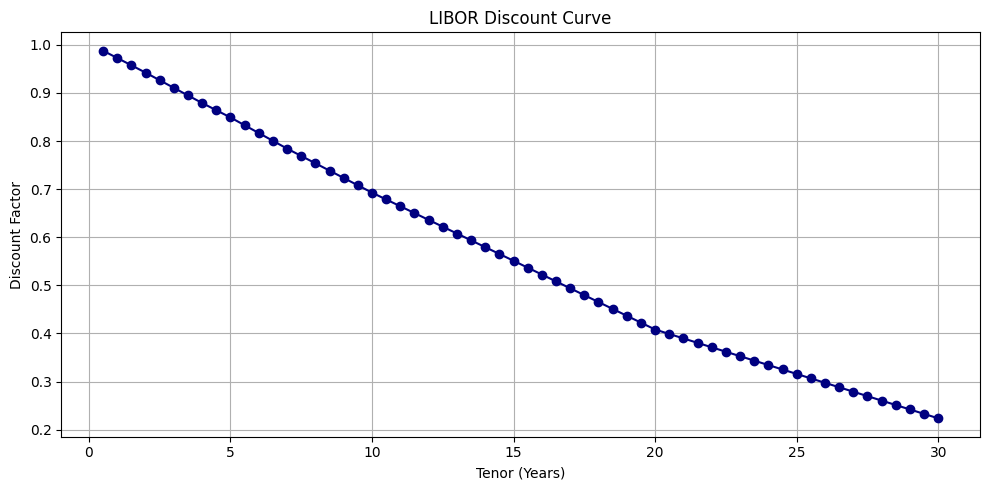

In [55]:
plot_discount_curve(ois_irs_rates_final, "LIBOR Discount Curve", column = "LIBOR DF")

#Forward Swap Rates

In [ ]:
ois_irs_rates_final.columns

Index(['Tenor', 'Rate', 'OIS DF', 'LIBOR DF', 'LIBOR Forward Rate'], dtype='object')

$$
S(T_i, T_{i+m}) = \frac{0.5 \times \sum_{n=i+1}^{i+m} D_o(0, T_n) \times L(T_{n-0.5}, T_n)}{0.5 \times \sum_{n=i+1}^{i+m} D_o(0, T_n)}
$$

In [26]:
def Forward_Swap_Rate_CALC(expiry, tenor):
    start_value = ois_irs_rates_final.loc[ois_irs_rates_final['Tenor'] == expiry, 'Tenor'].values[0]
    end = expiry + tenor
    end_value = ois_irs_rates_final.loc[ois_irs_rates_final['Tenor'] == end, 'Tenor'].values[0]
    indices = np.arange(start_value + 0.5, end_value + 0.5 , 0.5)
    PV_flt_sum, PV_fix_sum = 0, 0
    for i in indices:
        i = list(ois_irs_rates_final.index[ois_irs_rates_final["Tenor"]==i])[0]
        #Because it is collateralised we use overnight discount factor for discounting
        PV_flt_sum += 0.5 * ois_irs_rates_final.loc[i, 'OIS DF'] * ois_irs_rates_final.loc[i, 'LIBOR Forward Rate']
        PV_fix_sum += 0.5 * ois_irs_rates_final.loc[i, 'OIS DF']

    forward_swap_rate = PV_flt_sum / PV_fix_sum

    return forward_swap_rate

In [27]:
expiry = ['1Y', '5Y', '10Y']
tenors = ['1Y', "2Y", '3Y', '5Y', '10Y']
par_swap_rate = []
for expiries in expiry:
    for tenor in tenors:
      i = int(expiries.strip()[:-1])
      j = int(tenor.strip()[:-1])

      par_swap_rate.append(Forward_Swap_Rate_CALC(i, j))

par_swap_rate_df = np.array(par_swap_rate).reshape(3, 5)
par_swap_rate_df = pd.DataFrame(par_swap_rate_df, columns = tenors, index = expiry)
par_swap_rate_df

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


#Final Formatting

In [28]:
def safe_insert(df, position, column_name, values):
    if column_name not in df.columns:
        df.insert(position, column_name, values)

# Rename columns if needed
ois_irs_rates_final = ois_irs_rates_final.rename(columns={
    'Rate': 'LIBOR Rate',
    'OIS DF': 'OIS Discount Factor',
    'LIBOR DF': 'LIBOR Discount Factor'
})

# Use helper for inserting new columns safely
safe_insert(ois_irs_rates_final, 1, 'OIS Product', 'OIS')
safe_insert(ois_irs_rates_final, 2, 'OIS Rate', ois_rates1['Rate'])
safe_insert(ois_irs_rates_final, 3, 'OIS Forward Rate', ois_rates1['Forward Rate'])
safe_insert(ois_irs_rates_final, 6, 'LIBOR Product', 'IRS')

# Safe value assignment
if 'LIBOR Product' in ois_irs_rates_final.columns:
    ois_irs_rates_final.at[0, 'LIBOR Product'] = 'LIBOR'

# Move columns if they already exist (this is always safe to repeat)
if 'LIBOR Forward Rate' in ois_irs_rates_final.columns:
    ois_irs_rates_final.insert(7, 'LIBOR Forward Rate', ois_irs_rates_final.pop('LIBOR Forward Rate'))

if 'LIBOR Rate' in ois_irs_rates_final.columns:
    ois_irs_rates_final.insert(len(ois_irs_rates_final.columns) - 3, 'LIBOR Rate', ois_irs_rates_final.pop('LIBOR Rate'))


ois_irs_rates_final


,Tenor,OIS Product,OIS Rate,OIS Forward Rate,OIS Discount Factor,LIBOR Product,LIBOR Rate,LIBOR Forward Rate,LIBOR Discount Factor
0,0.5,OIS,0.002500,0.002498,0.998752,LIBOR,0.025000,0.025000,0.987654
1,1.0,OIS,0.003000,0.003493,0.997009,IRS,0.028000,0.031005,0.972577
2,1.5,OIS,0.003125,0.003494,0.995270,IRS,0.029000,0.031751,0.957378
3,2.0,OIS,0.003250,0.003495,0.993531,IRS,0.030000,0.032263,0.942179
4,2.5,OIS,0.003300,0.003520,0.991773,IRS,0.030750,0.034218,0.926330
5,3.0,OIS,0.003350,0.003545,0.990015,IRS,0.031500,0.034814,0.910482
6,3.5,OIS,0.003425,0.003745,0.988066,IRS,0.032000,0.035207,0.894731
7,4.0,OIS,0.003500,0.003946,0.986117,IRS,0.032500,0.035838,0.878981
8,4.5,OIS,0.003550,0.003971,0.984150,IRS,0.032750,0.034713,0.863985
9,5.0,OIS,0.003600,0.003996,0.982184,IRS,0.033000,0.035326,0.848989


In [ ]:
par_swap_rate_df.to_csv("Forward_Swap_Rate.csv", index=True)
ois_irs_rates_final.to_csv("Discount_Factor.csv", index=True)

In [ ]:
list_functions_with_purpose(globals())

Function Name                  Inputs                                   Purpose
----------------------------------------------------------------------------------------------------
list_functions_with_purpose    (module_globals)                         No description
tenor_to_years                 (tenor)                                  Convert tenor strings like '6m', '1y', etc. to fractional years.
plot_discount_curve            (interpolated_df, title, column='Discount Factor') No description
DF_to_OR                       (d, i)                                   No description
OR_to_DF                       (f, i)                                   No description
ois_df                         (x, i, h, ois_data, fix, flt)            No description
f                              (x)                                      No description
LIBOR_DF                       (i, m, DF_end, pv_flt)                   No description
calc_flt_leg                   (pv_flt, df)                    